# Training

*Creators: Lajos Bodo, Szilard Kosa*

Description: This is the main program. It consists of three bigger parts:
* First we load in the datasets. The first dataset is for training and validation. And the second one is for the umap visualization. 
* The second part is where we define the model with the custom loss function, and create a custom generator, which generates the triplets during training.
* The third part is the training itself, with the umap visualization. Before and after the training we create some figures in order to compare the development of the network.

**note:** The testing is done in another notebook.


## Loading Datasets

After you uploaded the datasets to your Google Drive in the following cell you have to specify their location.

In [0]:
# The first path is for the dataset created from the VGGFace2 database, for training and for validation.
hdf5_path_vgg = "drive/My Drive/Deeplearning/DB/dataset.hdf5"
# The second one is created from the LFW database for the UMAP display.
hdf5_path_lfw = "drive/My Drive/Deeplearning/dataset_lfw_umap.hdf5"

In [2]:
# mounting driver to get access to the datasets
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


There are some libraries that we have to install.

In [3]:
# to work with hdf5 format files
!pip install tables
# to create picture of the model
!pip install -q pydot
!apt install graphviz
# UMAP is an algorithm for dimension reduction
!pip install umap-learn
# for an interactive figure 
!pip install bokeh

    100% |████████████████████████████████| 3.8MB 9.9MB/s 
    100% |████████████████████████████████| 163kB 29.3MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  lib

Importing some necessary libraries and setting the seeds.

In [0]:
# To display images
import matplotlib.pyplot as plt
%matplotlib inline
# This library let's us work with hdf5 format files
import tables
# Fundamental package for scientific computing with Python
import numpy as np
# Used for printing the current progress only
from IPython.display import clear_output
# Setting seeds
import random as rn
import tensorflow as tf
np.random.seed(1)
rn.seed(2)
tf.set_random_seed(3)

### 1st dataset

In the next cells we load the first dataset. It contains almost 8000 persons and from each person there are 40 pictures. 90% of the people is used for training and 10% for validation. The triplet generator will generate a batch of triplets from a specified number of picture from a specified number of persons. For example we used 15 pictures from each person and for each batch the triplets were made using 16 consecutive person. So to make it easier when using the generator the pictures were stored in this way. Meaning in each element of the X_train list we store 15x16 pictures. And because we have 40 pictures from each person, when we finish loading the first 15 pictures from each person we repeat the process for the second 15 pictures. The same applies for the X_valid list.

**note:** To understand the triplet generator, you can find a more detailed description before its definition.

In [5]:
# number of pictures used for triplet generation from each person in the batch
picture_per_person = 15
# number of person in a batch
person_per_batch = 16
# 90% is used for training and 10% for validation
valid_split = 0.1
# there are 40 picures from each person in the dataset
max_picture_per_person = 40

# opening the dataset
hdf5_file = tables.open_file(hdf5_path_vgg, mode='r')
# number of pictures in the dataset
data_num = hdf5_file.root.images.shape[0]
print("Number of pictures: {}".format(data_num))
# number of person in the dataset
person_num = int(data_num/max_picture_per_person)
print("Number of person: {}".format(person_num))
# the max batch amount that can be created with this amount of people
batch_num = int(person_num/person_per_batch)
print("Max batch amount: {}".format(batch_num))
# 90% of the max batch number goes for training
train_batch_num = int(batch_num*(1-valid_split))
print("Number of batches used for training: {}".format(train_batch_num))
# 10% goes for validation
valid_batch_num = batch_num - train_batch_num
print("Number of batches used for validation: {}".format(valid_batch_num))
# number of pictures in a batch
picture_per_batch = picture_per_person*person_per_batch
print("Number of pictures in a batch: {}".format(picture_per_batch))
# index of the picture that separates the training pictures and the validation pictures
valid_index = train_batch_num*person_per_batch*max_picture_per_person
print("Valid index: {}".format(valid_index))

# load_num represents how many times can we load picture_per_person amount of pictures
# from a person without repeating picutres
# in the current case: 40/15=2
load_num = int(max_picture_per_person/picture_per_person)

Number of pictures: 310160
Number of person: 7754
Max batch amount: 484
Number of batches used for training: 435
Number of batches used for validation: 49
Number of pictures in a batch: 240
Valid index: 278400


In [6]:
# the following lists are used to store the training and the validation data
X_train = []
X_valid = []

# going through the dataset load_num times
for ln in range(load_num):
    # storing train data batch by batch
    for batch in range(train_batch_num):
        # we load one batch in the following list and then append it to X_train
        X = []
        for pic in range(picture_per_batch):
            index = batch*person_per_batch*max_picture_per_person + (pic//picture_per_person)*max_picture_per_person + pic%picture_per_person
            index += ln*picture_per_person
            X.append(hdf5_file.root.images[index]/255)
        X_train.append(X)
        # printing the process
        clear_output(wait=True)
        print("Loading: %.3f %%"%(float(batch)/float(train_batch_num-1)*100))

    # the validation list is filled up the same way
    for batch in range(valid_batch_num):
        X = []
        for pic in range(picture_per_batch):
            index = batch*person_per_batch*max_picture_per_person + (pic//picture_per_person)*max_picture_per_person + pic%picture_per_person
            index += valid_index + ln*picture_per_person
            X.append(hdf5_file.root.images[index]/255)
        X_valid.append(X)
        clear_output(wait=True)
        print("Loading: %.3f %%"%(float(batch)/float(valid_batch_num-1)*100))

hdf5_file.close()

Loading: 100.000 %


In [7]:
print("Length of the training list: {}".format(len(X_train)))
print("Length of the validation list: {}".format(len(X_valid)))

Length of the training list: 870
Length of the validation list: 98


### 2nd dataset

In the next cell we load the second dataset, which we will use later on to create the UMAP figures. This dataset contains 20 person and for each person has 20 pictures.

In [0]:
# Opening the dataset.
hdf5_file = tables.open_file(hdf5_path_lfw, mode='r')
data_num=hdf5_file.root.images.shape[0]
# Max picture number that can be loaded.
max_picture_num_umap = 20
max_person_num_umap = 20
# Number of pictures needed from one person.
# In this case we load all 20 pictures.
picture_num_umap = 20
# Amount of persons used.
# In this case all of them.
person_num_umap = 20

# The following lists are needed later on for the UMAP visualization.
# list to store the pictures
X_umap = []
# names of the persons
Y_umap = []
# each person gets a number as well
Y_color = []
# this list contains the names only one time
Y_name = []

# filling up the lists
for person in range(person_num_umap):
    X_umap.extend(hdf5_file.root.images[person*max_picture_num_umap:person*max_picture_num_umap+picture_num_umap])
    Y_umap.extend([hdf5_file.root.labels[person*max_picture_num_umap].decode("utf-8") for i in range(picture_num_umap)])
    Y_name.append(hdf5_file.root.labels[person*max_picture_num_umap].decode("utf-8"))
    Y_color.extend([person for i in range(picture_num_umap)])


hdf5_file.close()

Kofi_Annan


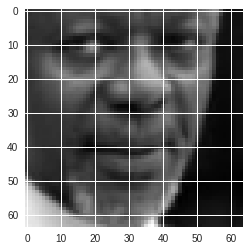

In [9]:
# checking lists
ind = 380
print(Y_umap[ind])
plt.imshow(X_umap[ind],cmap="gray")
plt.show()

## Defining the model

First we have to import the necessary libraries.

In [10]:
import keras
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.models import Model
from keras import backend as K
from keras import optimizers

Using TensorFlow backend.


In the next cell we define the vision_model. The architecture of the network is based on the OpenFace's implementation of the FaceNet nn4 model.  It is a GoogLeNet style Inception model. To make it easier to understand we create a picture of the model in the following cell after this.

In [0]:
# This definition is needed for local response normalization.
# The use of this is also mentioned in the FaceNet paper.
def LRN2D(x):
    return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

# Stem
digit_input = Input(shape=(64, 64, 1))

x = ZeroPadding2D(padding=(3, 3), input_shape=(64, 64, 1))(digit_input)
x = Conv2D(32, (7, 7), strides=(2, 2), name='conv1')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)
x = Lambda(LRN2D, name='lrn_1')(x)
x = Conv2D(32, (1, 1), name='conv2')(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = Conv2D(96, (3, 3), name='conv3')(x)
x = Activation('relu')(x)
x = Lambda(LRN2D, name='lrn_2')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D(pool_size=3, strides=2)(x)

# Inception3a
inception_3a_3x3 = Conv2D(48, (1, 1), name='inception_3a_3x3_conv1')(x)
inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
inception_3a_3x3 = Conv2D(64, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

inception_3a_5x5 = Conv2D(8, (1, 1), name='inception_3a_5x5_conv1')(x)
inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
inception_3a_5x5 = Conv2D(16, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

inception_3a_pool = MaxPooling2D(pool_size=2, strides=2)(x)
inception_3a_pool = Conv2D(16, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
inception_3a_pool = Activation('relu')(inception_3a_pool)
inception_3a_pool = ZeroPadding2D(padding=((2, 2), (2, 2)))(inception_3a_pool)

inception_3a_1x1 = Conv2D(32, (1, 1), name='inception_3a_1x1_conv')(x)
inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=-1)

# Inception3b
inception_3b_3x3 = Conv2D(48, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
inception_3b_3x3 = Conv2D(64, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

inception_3b_5x5 = Conv2D(16, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
inception_3b_5x5 = Conv2D(32, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

inception_3b_pool = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(inception_3a)
inception_3b_pool = Conv2D(32, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
inception_3b_pool = Activation('relu')(inception_3b_pool)
inception_3b_pool = ZeroPadding2D(padding=(2, 2))(inception_3b_pool)

inception_3b_1x1 = Conv2D(32, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=-1)

# Inception3c
inception_3c_3x3 = Conv2D(64, (1, 1), name='inception_3c_3x3_conv1')(inception_3b)
inception_3c_3x3 = Activation('relu')(inception_3c_3x3)
inception_3c_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3c_3x3)
inception_3c_3x3 = Conv2D(128, (3, 3), strides=(2, 2), name='inception_3c_3x3_conv2')(inception_3c_3x3)
inception_3c_3x3 = Activation('relu')(inception_3c_3x3)


inception_3c_5x5 = Conv2D(16, (1, 1), name='inception_3c_5x5_conv1')(inception_3b)
inception_3c_5x5 = Activation('relu')(inception_3c_5x5)
inception_3c_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3c_5x5)
inception_3c_5x5 = Conv2D(32, (5, 5), strides=(2, 2), name='inception_3c_5x5_conv2')(inception_3c_5x5)
inception_3c_5x5 = Activation('relu')(inception_3c_5x5)

inception_3c_pool = MaxPooling2D(pool_size=2, strides=2)(inception_3b)

inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=-1)

#inception 4a
inception_4a_3x3 = Conv2D(48, (1, 1), name='inception_4a_3x3_conv1')(inception_3c)
inception_4a_3x3 = Activation('relu')(inception_4a_3x3)
inception_4a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_4a_3x3)
inception_4a_3x3 = Conv2D(96, (3, 3), strides=(1, 1), name='inception_4a_3x3_conv2')(inception_4a_3x3)
inception_4a_3x3 = Activation('relu')(inception_4a_3x3)

inception_4a_5x5 = Conv2D(16, (1, 1), name='inception_4a_5x5_conv1')(inception_3c)
inception_4a_5x5 = Activation('relu')(inception_4a_5x5)
inception_4a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_4a_5x5)
inception_4a_5x5 = Conv2D(32, (5, 5), strides=(1, 1), name='inception_4a_5x5_conv2')(inception_4a_5x5)
inception_4a_5x5 = Activation('relu')(inception_4a_5x5)

inception_4a_pool = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(inception_3c)
inception_4a_pool = Conv2D(64, (1, 1), name='inception_4a_pool_conv')(inception_4a_pool)
inception_4a_pool = Activation('relu')(inception_4a_pool)
inception_4a_pool = ZeroPadding2D(padding=(1, 1))(inception_4a_pool)

inception_4a_1x1 = Conv2D(128, (1, 1), name='inception_4a_1x1_conv')(inception_3c)
inception_4a_1x1 = Activation('relu')(inception_4a_1x1)

inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=-1)

#inception4e
inception_4e_3x3 = Conv2D(80, (1, 1), name='inception_4e_3x3_conv1')(inception_4a)
inception_4e_3x3 = Activation('relu')(inception_4e_3x3)
inception_4e_3x3 = ZeroPadding2D(padding=(1, 1))(inception_4e_3x3)
inception_4e_3x3 = Conv2D(128, (3, 3), strides=(2, 2), name='inception_4e_3x3_conv2')(inception_4e_3x3)
inception_4e_3x3 = Activation('relu')(inception_4e_3x3)

inception_4e_5x5 = Conv2D(32, (1, 1), name='inception_4e_5x5_conv1')(inception_4a)
inception_4e_5x5 = Activation('relu')(inception_4e_5x5)
inception_4e_5x5 = ZeroPadding2D(padding=(2, 2))(inception_4e_5x5)
inception_4e_5x5 = Conv2D(64, (5, 5), strides=(2, 2), name='inception_4e_5x5_conv2')(inception_4e_5x5)
inception_4e_5x5 = Activation('relu')(inception_4e_5x5)

inception_4e_pool = MaxPooling2D(pool_size=2, strides=2)(inception_4a)

inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=-1)

#inception5a
inception_5a_3x3 = Conv2D(48, (1, 1), name='inception_5a_3x3_conv1')(inception_4e)
inception_5a_3x3 = Activation('relu')(inception_5a_3x3)
inception_5a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_5a_3x3)
inception_5a_3x3 = Conv2D(192, (3, 3), strides=(1, 1), name='inception_5a_3x3_conv2')(inception_5a_3x3)
inception_5a_3x3 = Activation('relu')(inception_5a_3x3)

inception_5a_pool = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(inception_4e)
inception_5a_pool = Conv2D(48, (1, 1), name='inception_5a_pool_conv')(inception_5a_pool)
inception_5a_pool = Activation('relu')(inception_5a_pool)
inception_5a_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_5a_pool)

inception_5a_1x1 = Conv2D(128, (1, 1), name='inception_5a_1x1_conv')(inception_4e)
inception_5a_1x1 = Activation('relu')(inception_5a_1x1)

inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=-1)

#inception_5b
inception_5b_3x3 = Conv2D(48, (1, 1), name='inception_5b_3x3_conv1')(inception_5a)
inception_5b_3x3 = Activation('relu')(inception_5b_3x3)
inception_5b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_5b_3x3)
inception_5b_3x3 = Conv2D(192, (3, 3), strides=(1, 1), name='inception_5b_3x3_conv2')(inception_5b_3x3)
inception_5b_3x3 = Activation('relu')(inception_5b_3x3)

inception_5b_pool =  MaxPooling2D(pool_size=2, strides=2)(inception_5a)
inception_5b_pool = Conv2D(48, (1, 1), name='inception_5b_pool_conv')(inception_5b_pool)
inception_5b_pool = Activation('relu')(inception_5b_pool)
inception_5b_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_5b_pool)

inception_5b_1x1 = Conv2D(128, (1, 1), name='inception_5b_1x1_conv')(inception_5a)
inception_5b_1x1 = Activation('relu')(inception_5b_1x1)

inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=-1)

av_pool = AveragePooling2D(pool_size=(2, 2), strides=(1, 1))(inception_5b)
reshape_layer = Flatten()(av_pool)
dense_layer = Dense(128, name='dense_layer')(reshape_layer)

# The next layer's job is to force the output vector on a unit hypersphere.
norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

vision_model = Model(digit_input, norm_layer)

In [12]:
# Creating the picture of the model.
from keras.utils.vis_utils import plot_model
plot_model(vision_model, show_shapes=True, show_layer_names= True)
from IPython.display import Image, display
display(Image('drive/My Drive/Colab Notebooks/model.png'))

In [13]:
vision_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 32)   1600        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           conv1[0][0]                      
__________________________________________________________________________________________________
zero_paddi

During training we need a model with three inputs and three outputs. In the following cell we create a model just like that, using the previously defined vision_model.

In [0]:
# defining the inputs
in_a = Input(shape=(64, 64, 1))
in_p = Input(shape=(64, 64, 1))
in_n = Input(shape=(64, 64, 1))

# defining the outputs
out_a = vision_model(in_a)
out_p = vision_model(in_p)
out_n = vision_model(in_n)

concatenated = keras.layers.concatenate([out_a, out_p, out_n])

model = Model([in_a, in_p, in_n], concatenated)

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          955192      input_2[0][0]                    
                                                                 input_3[0][0]                    
          

The following function is a custom loss function based on the one used at https://thelonenutblog.wordpress.com/2018/02/13/how-to-potty-train-a-siamese-network/
The dimensions been modified to match the one mentioned in the FaceNet paper.

In [0]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """

    anchor = y_pred[:,:128]
    positive = y_pred[:,128:256]
    negative = y_pred[:,256:]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

Finally we compile the model. We use adam optimizer during training.

In [0]:
adam = optimizers.Adam(0.0001)
# sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=adam,
                  loss=triplet_loss)

### Custom generator

Our goal is to teach the network so that when given two image it can tell how similar the persons on them look.
The optimization of the network is done by a triplet loss function according to the [FaceNet](https://arxiv.org/abs/1503.03832) documentation. The triplets consists of three pictures, where the first two are from the same person and the third one is from a different person.

![pic2](https://qph.fs.quoracdn.net/main-qimg-17cd47a61fa2e0472d569040aacdf2fc)

 The problem is that if these triplets are generated randomly, after a short period of time the network will learn to distinguish them pretty well. Meaning the network can't learn from these triplets anymore.  The solution to this problem is to teach it on triplets that are hard to distinguish. We are using the [online triplet mining](https://omoindrot.github.io/triplet-loss) technique to create these triplets. Which means the training data consists of batches containing a defined amount of pictures from the defined number of people. The triplets are created after their embeddings are calcutated. The anchor and the positive pictures are paired in every possible combination. And after that a semi hard negative is chosen as the third picture.


In [0]:
# for the combinations
import itertools

# we create another triplet loss function using numpy
def tripletloss(anchor, positive, negative, alpha = 0.2):
    # distance between the anchor and the positive
    pos_dist = np.sum(np.square(anchor-positive))

    # distance between the anchor and the negative
    neg_dist = np.sum(np.square(anchor-negative))

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = np.maximum(basic_loss,0.0)
 
    return loss

def triplet_generator(network, X, b_size = 100, for_training = True):
    """
    Own triplet generator
    Arguments:
    network      -- the network that we want to use for the triplet generation
    X            -- list containing a list with a previously defined number of images
    b_size       -- the number of triplets we want to yield
    for_training -- if set to false the generator doesn't search for hard triplets
                    in that case it can be used for validation
    
    Yields:
    ( batch_x, batch_y ) -- the model expects a tuple so we yield back some dummy 
                            y values as well next to the triplets
    """
    while True:
        # going through the previously created picture batches
        for index in range(len(X)):
            # if we want to find hard triplets
            if for_training:
                preds = []
                imgs = []
                # Loading in pictures in the imgs list and saving their embeddings  in the preds list.
                # The network has three inputs so the predictions are done on three images at the same time.
                for i in range(picture_per_batch//3):
                    for j in range(3):
                        # dimension expansion
                        img = np.expand_dims(X[index][i*3+j], axis=0)
                        img = np.expand_dims(img, axis=3)
                        imgs.append(img)
                    pred = network.predict([imgs[-3],imgs[-2],imgs[-1]])[0]
                    preds.extend([pred[:128],pred[128:256],pred[256:]])
                if picture_per_batch%3>0:
                    for i in range(picture_per_batch%3):
                        # dimension expansion
                        img = np.expand_dims(X[index][picture_per_batch//3*3+i], axis=0)
                        img = np.expand_dims(img, axis=3)
                        imgs.append(img)
                    pred = network.predict([imgs[-3],imgs[-2],imgs[-1]])[0]
                    if picture_per_batch%3 ==1:
                        preds.append(pred[256:])
                    else:
                        preds.extend([pred[128:256],pred[256:]])
                
                # creating all of the possible picture combinations per person
                duos = []
                img_duos = []
                for i in range(person_per_batch):
                    for duo in itertools.combinations(imgs[i*picture_per_person:(i+1)*picture_per_person],2):
                        img_duos.append(duo)
                    for duo in itertools.combinations(preds[i*picture_per_person:(i+1)*picture_per_person],2):
                        duos.append(duo)
                # creating the triplets
                triplets = []
                img_triplets = []
                # iterating through every person
                for i in range(person_per_batch):
                    # the number of picture combinations per person
                    dn = int(len(duos)/person_per_batch)
                    # iterating through all the combinations, and finding the right triplets
                    for j in range(dn):
                        ind = dn*i+j
                        iter = 0
                        found = False
                        # Iterating through the whole batch to find a semi-hard negative.
                        # If none of them is suitable, then that combination is discarded.
                        while iter<picture_per_batch and not found:
                            if iter not in range(i*picture_per_person,(i+1)*picture_per_person) and tripletloss(duos[ind][0],duos[ind][1],preds[iter]) > 0 and tripletloss(duos[ind][0],duos[ind][1],preds[iter]) < 0.2:
                                triplets.append([duos[ind][0],duos[ind][1],preds[iter]])
                                img_triplets.append([img_duos[ind][0],img_duos[ind][1],imgs[iter]])
                                found = True
                            iter += 1
                            
            # if it is for validation then it is not necessary to find a semi-hard negítive
            else:
                imgs = []
                # loading in pictures in the imgs list
                for i in range(picture_per_batch):
                    img = np.expand_dims(X[index][i], axis=0)
                    img = np.expand_dims(img, axis=3)
                    imgs.append(img)
                # creating all of the possible picture combinations per person
                img_duos = []
                for i in range(person_per_batch):
                    for duo in itertools.combinations(imgs[i*picture_per_person:(i+1)*picture_per_person],2):
                        img_duos.append(duo)
                # creating the triplets
                img_triplets = []
                for i in range(person_per_batch):
                    # the number of picture combinations per person
                    dn = int(len(img_duos)/person_per_batch)
                    # iterating through all the combinations
                    for j in range(dn):
                        ind = dn*i+j
                        iter = 0
                        found = False
                        # Iterating through the whole batch to find a good negative.
                        while iter<picture_per_batch and not found:
                            if iter not in range(i*picture_per_person,(i+1)*picture_per_person):
                                img_triplets.append([img_duos[ind][0],img_duos[ind][1],imgs[iter]])
                                found = True
                            iter += 1
            batch_size = len(img_triplets)
            # If there are triplets to yield
            if batch_size>0:
                batch1 = np.zeros((batch_size,64,64,1))
                batch2 = np.zeros((batch_size,64,64,1))
                batch3 = np.zeros((batch_size,64,64,1))
                # putting the triplets in numpy array, in a shuffled order
                for i,b in enumerate(np.random.RandomState(seed=42).permutation(batch_size)):
                    batch1[i] = img_triplets[b][0][0,...]
                    batch2[i] = img_triplets[b][1][0,...]
                    batch3[i] = img_triplets[b][2][0,...]
                # sending whole batches
                for i in range(batch_size//b_size):
                    batch_x = [batch1[i*b_size:(i+1)*b_size],batch2[i*b_size:(i+1)*b_size],batch3[i*b_size:(i+1)*b_size]]
                    batch_y = np.zeros(b_size)
                    yield( batch_x, batch_y )
                # sending the remainder
                if(batch_size%b_size>0):
                    batch_x = [batch1[batch_size//b_size*b_size:],\
                               batch2[batch_size//b_size*b_size:],batch3[batch_size//b_size*b_size:]]
                    batch_y = np.zeros(batch_size%b_size)
                    yield( batch_x, batch_y )

## Training

### UMAP on the images

In the first part we created some figures, to show how it looks like to use dimension reduction on the images itself.
We use 64x64 images, so they can be imagined as points in the 4096th dimension. For the reduction we used the newly released [UMAP algorithm.](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) These cells are based on their MNIST example.

In [0]:
# necessary libraries
import pandas as pd
import umap

In [20]:
# We have to flatten the pictures before the reduction.
X_umap_flat = [X_umap[i].reshape(-1) for i in range(len(X_umap))]
X_umap_flat[0].shape

(4096,)

First we have to create a reducer object. Then we pass the data we want the model to learn from, to the fit method.

In [21]:
reducer = umap.UMAP(random_state=42)
reducer.fit(X_umap_flat)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=42,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

Now we can create the reduced values. By default, UMAP reduces down to 2D.

In [22]:
embedding = reducer.transform(X_umap_flat)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(400, 2)

After that we can plot the results.

Text(0.5,1,'UMAP projection of the face images')

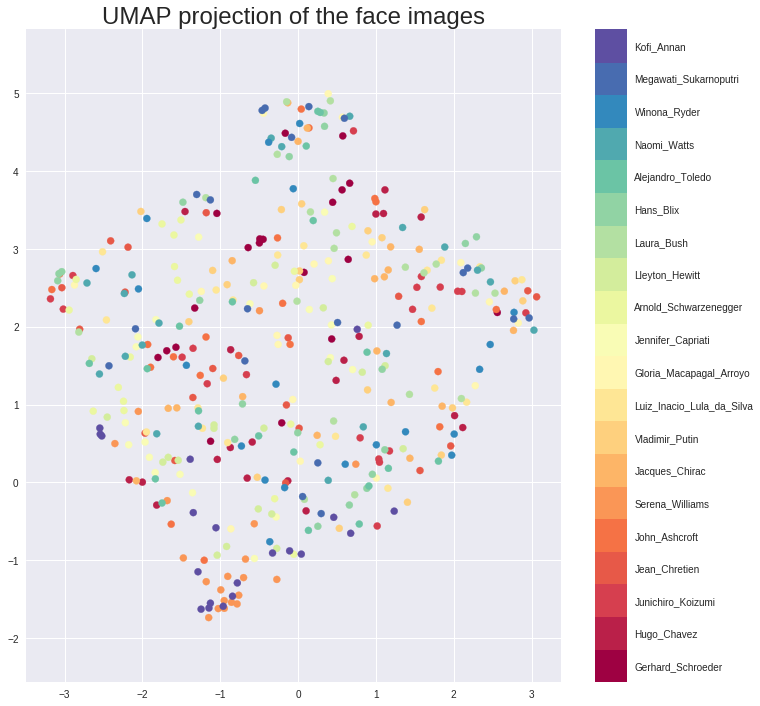

In [23]:
plt.rcParams["figure.figsize"] = [12,12]
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_color, cmap='Spectral', s=50)
plt.gca().set_aspect('equal', 'datalim')
# adding colorbar
cbar = plt.colorbar(boundaries=np.arange(person_num_umap+1)-0.5, ticks=range(person_num_umap))
cbar.ax.set_yticklabels(Y_name)
plt.title('UMAP projection of the face images', fontsize=24)

At first it looks like the points are complitly random. To get a better idea of why it looks like this it is helpful to see the actual faces involve. It can be done using [bokeh](https://bokeh.pydata.org/en/latest/) and mouseover tooltips of the images.

First we’ll need to encode all the images for inclusion in a dataframe.

In [0]:
from io import BytesIO
from PIL import Image
import base64

In [0]:
def embeddable_image(data):
    img_data = data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((128, 128), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

Next we need to load up bokeh and the various tools from it that will be needed to generate a suitable interactive plot.

In [0]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10,inferno,Category20

Finally we generate the plot itself with a custom hover tooltip that embeds the image of the face in question in it, along with the persons name.

In [27]:
output_notebook()
digits_df = pd.DataFrame(embedding, columns=('x', 'y'))
digits_df['name'] = [str(x) for x in Y_umap]
digits_df['image'] = list(map(embeddable_image, X_umap))

datasource = ColumnDataSource(digits_df)
color_mapping = CategoricalColorMapper(factors=Y_name,
                                       palette=Category20[20])

plot_figure = figure(
    title='UMAP projection of the face images',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: top; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 12px; color: #224499'>Person:</span>
        <span style='font-size: 18px'>@name</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='name', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=10
)
show(plot_figure)

Output hidden; open in https://colab.research.google.com to view.

If we look at it in more detail, we can see that there is a logic in the layout of the points. For example on the left the faces look on the right and on the right the faces look on the left. Also in the bottom of the figure the points belong to darker images.

### UMAP on the embeddings  before training

In this section we repeat the same process, but instead of the pictures now we use it to reduce the 128th dimensional embeddings.  These figures are created for comparison. So after the training we can see how much the model learned.

In [0]:
# this function helps to create the predictions
def model_preds(network, X_test):
    preds = []
    for i in range(0,len(X_test)):
        img1 = np.expand_dims(X_test[i]/255., axis=0)
        img1 = np.expand_dims(img1, axis=3)
        preds.append(network.predict([img1,img1,img1])[0][:128])
    return preds

In [29]:
preds = model_preds(model,X_umap)
reducer = umap.UMAP(random_state=42)
reducer.fit(preds)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=42,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

In [30]:
embedding = reducer.transform(preds)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(400, 2)

Text(0.5,1,'UMAP projection of the embeddings')

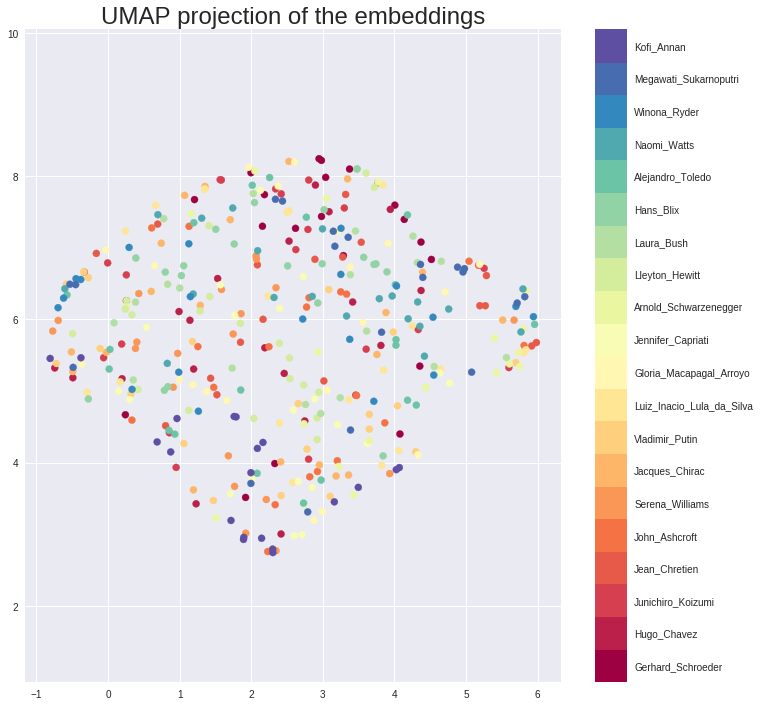

In [31]:
plt.rcParams["figure.figsize"] = [12,12]
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_color, cmap='Spectral', s=50)
plt.gca().set_aspect('equal', 'datalim')
# adding colorbar
cbar = plt.colorbar(boundaries=np.arange(person_num_umap+1)-0.5, ticks=range(person_num_umap))
cbar.ax.set_yticklabels(Y_name)
plt.title('UMAP projection of the embeddings', fontsize=24)

In [32]:
output_notebook()
digits_df = pd.DataFrame(embedding, columns=('x', 'y'))
digits_df['name'] = [str(x) for x in Y_umap]
digits_df['image'] = list(map(embeddable_image, X_umap))

datasource = ColumnDataSource(digits_df)
color_mapping = CategoricalColorMapper(factors=Y_name,
                                       palette=Category20[20])

plot_figure = figure(
    title='UMAP projection of the embeddings',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: top; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 12px; color: #224499'>Person:</span>
        <span style='font-size: 18px'>@name</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='name', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=10
)
show(plot_figure)

Output hidden; open in https://colab.research.google.com to view.

This figure looks a lot like the one using only the image pixels. The model's weights are still random so it is no surprise that there aren't many stuctures in the points.

### Training the model

Displaying triplets from the first training batch generated by the triplet_generator.

SHAPE OF THE BATCH: (60, 64, 64, 1)
1th Triplets of 60:
Positive distance: 0.0065041761845350266
Negative distance: 0.012473257258534431
Prediction: 0.19:


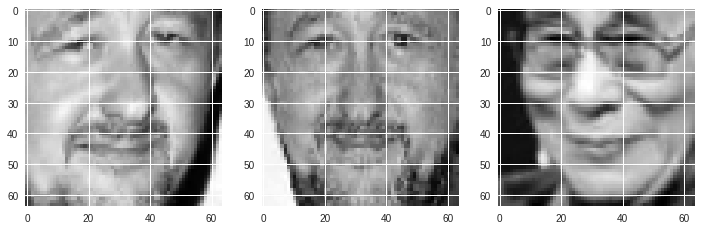

2th Triplets of 60:
Positive distance: 0.0024375957436859608
Negative distance: 0.007779546082019806
Prediction: 0.19:


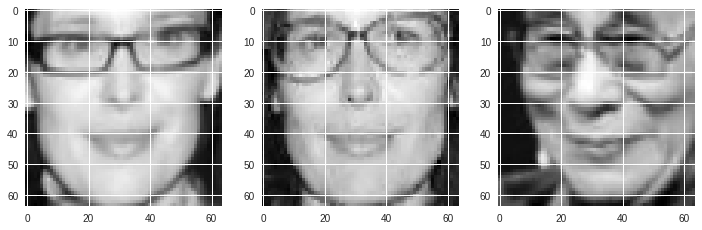

3th Triplets of 60:
Positive distance: 0.013055204413831234
Negative distance: 0.014325273223221302
Prediction: 0.20:


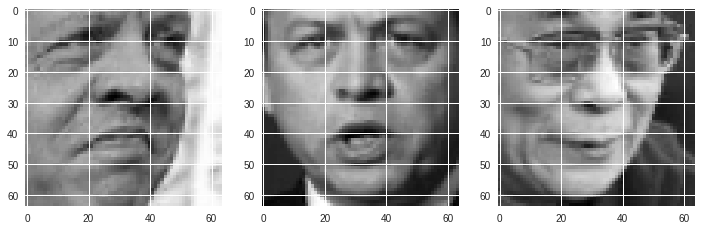

4th Triplets of 60:
Positive distance: 0.008395618759095669
Negative distance: 0.013337532058358192
Prediction: 0.20:


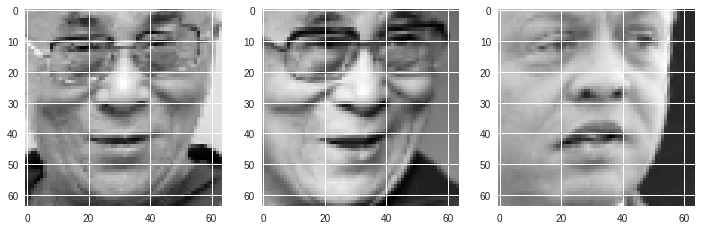

5th Triplets of 60:
Positive distance: 0.015535295009613037
Negative distance: 0.017238974571228027
Prediction: 0.20:


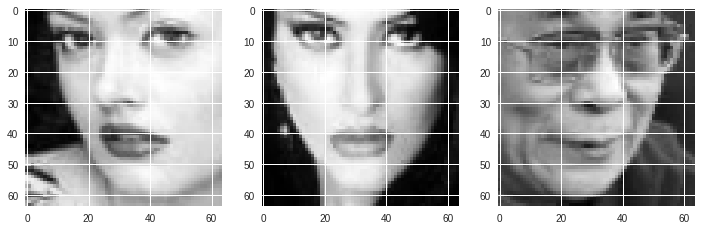

In [33]:
# creating an instance of the generator
generator = triplet_generator(model, X_train, b_size = 60)
i = 0
for b in generator:
    print("SHAPE OF THE BATCH: {}".format(b[0][2].shape))
    for tri in range(5):
        anch = np.expand_dims(b[0][0][tri,...], axis=0)
        pos = np.expand_dims(b[0][1][tri,...], axis=0)
        neg = np.expand_dims(b[0][2][tri,...], axis=0)
        print("{}th Triplets of {}:".format(tri+1,len(b[1])))
        # creating predictions
        preds = model.predict([anch,pos,neg])[0]
        anch_pred = preds[:128]
        pos_pred = preds[128:256]
        neg_pred = preds[256:]
        print("Positive distance: {}".format(np.sum(np.square(anch_pred-pos_pred))))
        print("Negative distance: {}".format(np.sum(np.square(anch_pred-neg_pred))))
        loss = tripletloss(anch_pred,pos_pred,neg_pred)
        print("Prediction: %.2f:"%(loss))
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(anch[0][:,:,0],cmap="gray")
        axarr[1].imshow(pos[0][:,:,0],cmap="gray")
        axarr[2].imshow(neg[0][:,:,0],cmap="gray")
        plt.show()
    i = i+1
    if i > 0:
        break

Training the model with the custom generators. The training is set to only two epochs just to demonstrate how it would look like.

In [34]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# We use early stopping.
patience=5
early_stopping=EarlyStopping(patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='drive/My Drive/Colab Notebooks/weights.hdf5', save_best_only=True, verbose=1)

train_generator = triplet_generator(model, X_train, b_size = 840)
valid_generator = triplet_generator(model, X_valid, b_size = 840, for_training = False)
history = model.fit_generator(
        train_generator,
        steps_per_epoch=870*2,
        epochs=2,
        validation_data=valid_generator,
        validation_steps = 98*2,
        verbose=1,
        callbacks=[checkpointer, early_stopping])

Epoch 1/2
1740/1740 [==============================] - 5258s 3s/step - loss: 0.1143 - val_loss: 0.0616

Epoch 00001: val_loss improved from inf to 0.06155, saving model to drive/My Drive/Colab Notebooks/weights.hdf5
Epoch 2/2
1740/1740 [==============================] - 6001s 3s/step - loss: 0.0893 - val_loss: 0.0450

Epoch 00002: val_loss improved from 0.06155 to 0.04505, saving model to drive/My Drive/Colab Notebooks/weights.hdf5


In [0]:
from keras.models import load_model
# We have to load back the best model
model = load_model('drive/My Drive/Colab Notebooks/weights.hdf5', custom_objects={'triplet_loss': triplet_loss,'tf':tf})

Text(0.5,1,'Training and validation loss')

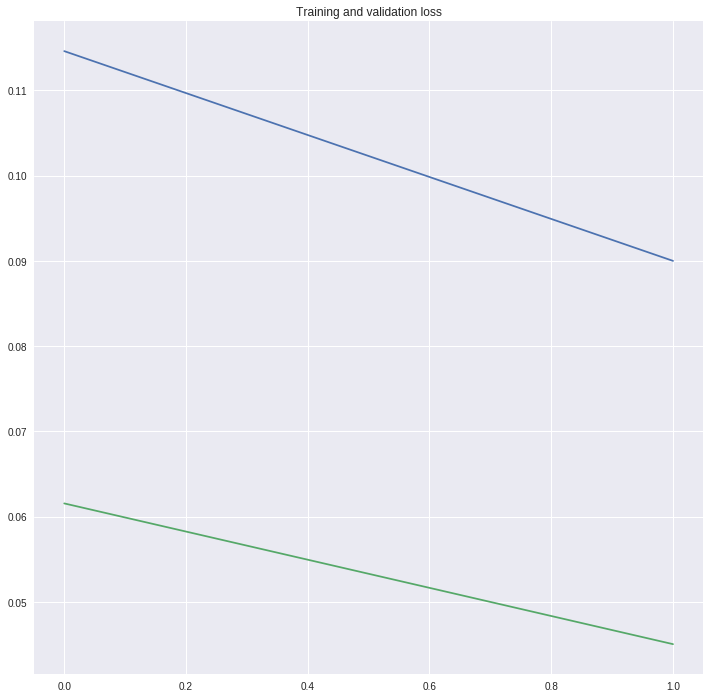

In [36]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(loss))

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Displaying triplets from the first validation batch generated by the triplet_generator. It is visible that after only two epochs the loss went down significantly.

SHAPE OF THE BATCH: (100, 64, 64, 1)
1th Triplets of 100:
0.3705209
0.8567473
Prediction: 0.00:


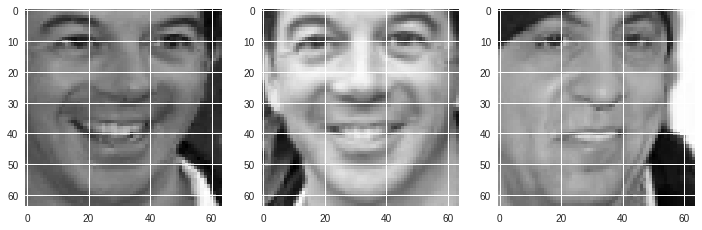

2th Triplets of 100:
0.1587119
1.7105038
Prediction: 0.00:


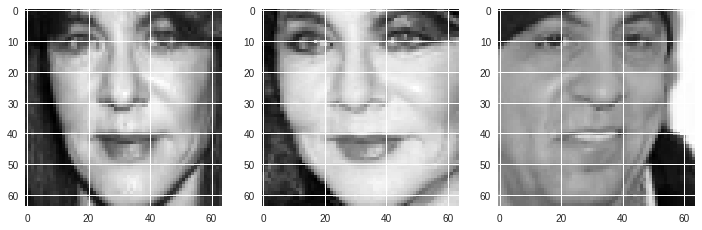

3th Triplets of 100:
0.2097964
1.3730913
Prediction: 0.00:


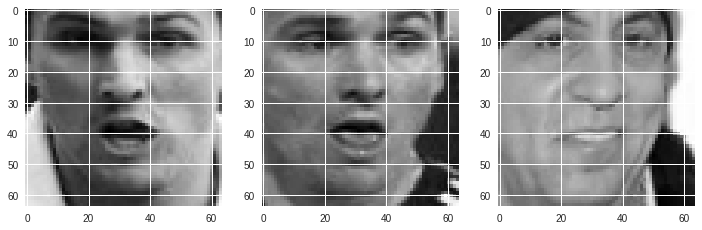

4th Triplets of 100:
0.273899
1.4901167
Prediction: 0.00:


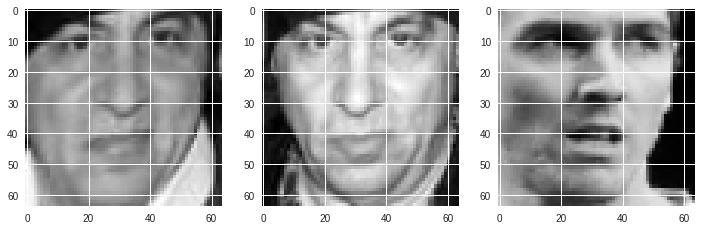

5th Triplets of 100:
0.6042953
0.7328266
Prediction: 0.07:


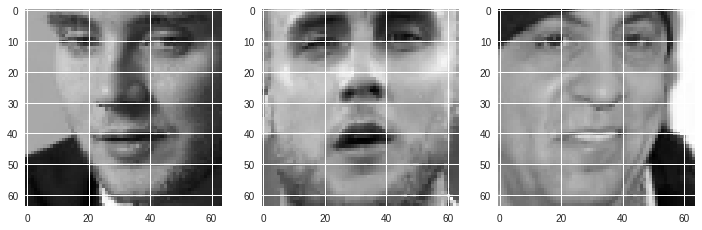

In [37]:
generator = triplet_generator(model, X_valid, for_training = False)
i = 0
for b in generator:
    print("SHAPE OF THE BATCH: {}".format(b[0][2].shape))
    for tri in range(5):
        anch = np.expand_dims(b[0][0][tri,...], axis=0)
        pos = np.expand_dims(b[0][1][tri,...], axis=0)
        neg = np.expand_dims(b[0][2][tri,...], axis=0)
        print("{}th Triplets of {}:".format(tri+1,len(b[1])))
        preds = model.predict([anch,pos,neg])[0]
        anch_pred = preds[:128]
        pos_pred = preds[128:256]
        neg_pred = preds[256:]
        print(np.sum(np.square(anch_pred-pos_pred)))
        print(np.sum(np.square(anch_pred-neg_pred)))
        loss = tripletloss(anch_pred,pos_pred,neg_pred)
        print("Prediction: %.2f:"%(loss))
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(anch[0][:,:,0],cmap="gray")
        axarr[1].imshow(pos[0][:,:,0],cmap="gray")
        axarr[2].imshow(neg[0][:,:,0],cmap="gray")
        plt.show()
    i = i+1
    if i > 0:
        break

### UMAP on the embeddings after training

Let's repeat the embedding visualization! But this time we use a trained model. In the next cell we can load an already trained model. This way we don't have to repeate the training every time to get the figures.

In [0]:
from keras.models import load_model
# Here we load our best model.
model = load_model('drive/My Drive/Colab Notebooks/weights_02_d.hdf5', custom_objects={'triplet_loss': triplet_loss,'tf':tf})

In [39]:
preds = model_preds(model,X_umap)
reducer = umap.UMAP(random_state=42)
reducer.fit(preds)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=42,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

In [40]:
embedding = reducer.transform(preds)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(400, 2)

Text(0.5,1,'UMAP projection of the embeddings')

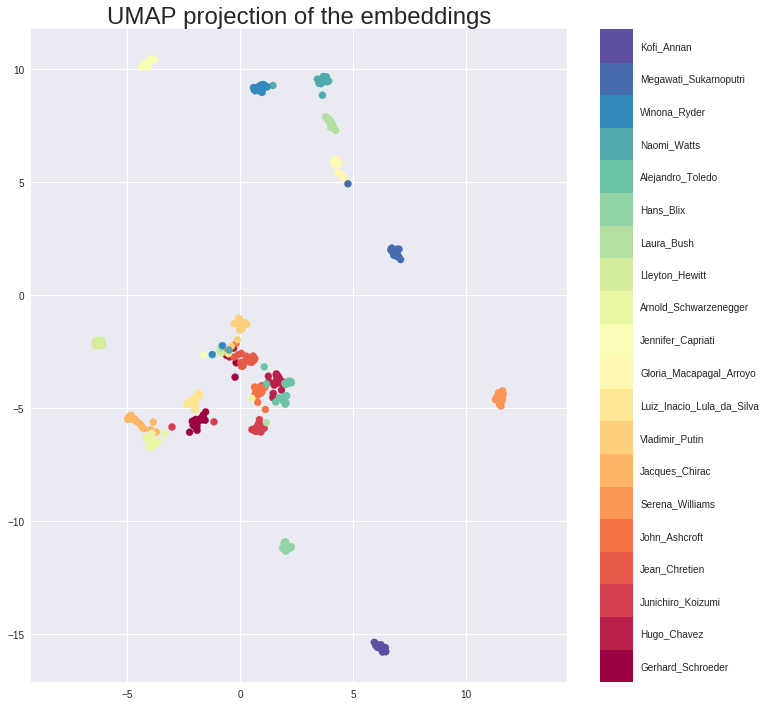

In [41]:
plt.rcParams["figure.figsize"] = [12,12]
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_color, cmap='Spectral', s=50)
plt.gca().set_aspect('equal', 'datalim')
# adding colorbar
cbar = plt.colorbar(boundaries=np.arange(person_num_umap+1)-0.5, ticks=range(person_num_umap))
cbar.ax.set_yticklabels(Y_name)
plt.title('UMAP projection of the embeddings', fontsize=24)

In [42]:
output_notebook()
digits_df = pd.DataFrame(embedding, columns=('x', 'y'))
digits_df['name'] = [str(x) for x in Y_umap]
digits_df['image'] = list(map(embeddable_image, X_umap))

datasource = ColumnDataSource(digits_df)
color_mapping = CategoricalColorMapper(factors=Y_name,
                                       palette=Category20[20])

plot_figure = figure(
    title='UMAP projection of the embeddings',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: top; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 12px; color: #224499'>Person:</span>
        <span style='font-size: 18px'>@name</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='name', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=10
)
show(plot_figure)

Output hidden; open in https://colab.research.google.com to view.

This time we can see that the pictures belonging to one person are closer to each other. It also makes it easier to understand how such a network can be used for face recognition. When two embeddings are close to each other that means they look similar. So the identification can be done by checking the distances of the embeddings.